# Encoder


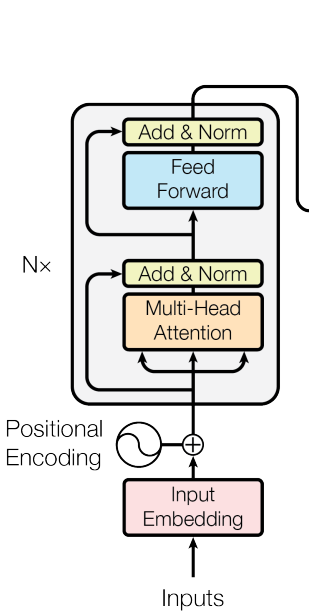

### Self Attention

$\text{Attention}(Q, K, V) = softmax\left(\frac{QK^T}{\sqrt{d_k}}\right)V$

$
\text{MultiHead}(Q, K, V) = \text{Concat}(head_1, ..., head_h) W^O \\
\text{where } head_i = \text{Attention}(Q W_i^Q, K W_i^K, V W_i^V)
$

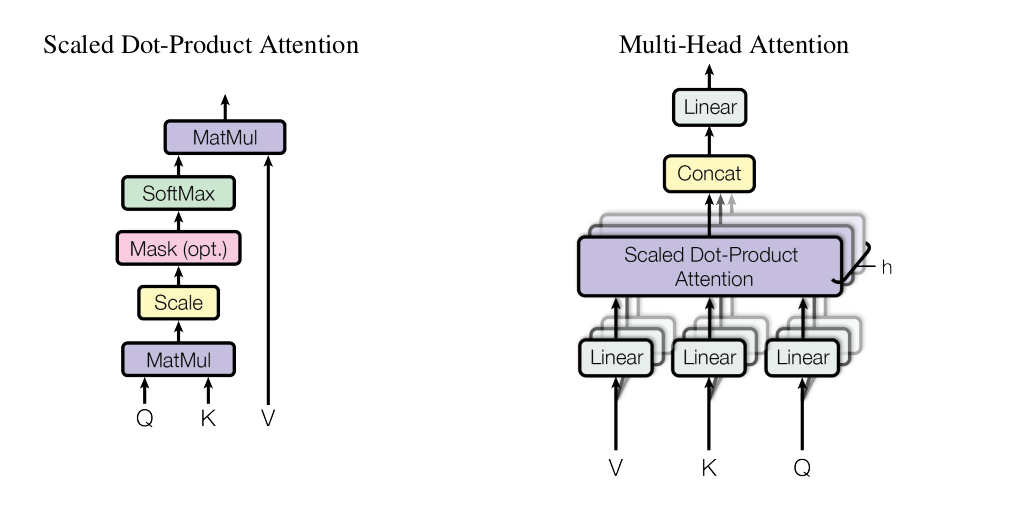

### position based Feed Forward network

$FFN(x)=max(0,x\cdot W_1+b_1)\cdot W_2+b_2$

Here as we are taking max with zero so practically that is ReLU activation. So our final equation becomes,

$FFN(x) = ReLU(x\cdot W_1+b_1)\cdot W_2+b_2$

In [16]:
import torch
import torch.nn as nn
from copy import deepcopy
import math

def scaled_dot_product_attention(q,k,v,mask = None):
    # q,k,v = 30 x 8 x 200 x 64
    d_k = q.shape[-1] # 64
    scaled = torch.matmul(q,k.transpose(-1,-2))/math.sqrt(d_k) # q = 30 x 8 x 200 x 64; k.T = 30 x 8 x 64 x 200 ; result = 30 x 8 x 200 x 200; it is like each word in row vs in col.
    if mask:
        scaled+=mask
    attention = torch.softmax(scaled,dim=-1) # 30 x 8 x 200 x 200; no change in shape
    values = torch.matmul(attention,v) # attention = 30 x 8 x 200 x 200 ; v = 30 x 8 x 200 x 64 ; values = 30 x 8 x 200 x 64 ; basic matrix multiplication accross last two dim
    return values,attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model,num_heads) -> None:
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model # 512
        self.num_heads = num_heads # 8
        self.head_dim = d_model//num_heads # 512/8 = 64
        self.qkv_layer = nn.Linear(d_model,3*d_model) # input = 512 ; output = 1536 i.e. each of the 512 dim input word is projected along 3 planes to get q k and v each of dim 512
        self.linear_layer = nn.Linear(d_model,d_model)
    def forward(self,x, mask = None):
        batch_size,seq_length, d_model = x.shape #30, 200, 512
        qkv = self.qkv_layer(x) # 30 x 200 x 1536
        qkv = qkv.view(batch_size,seq_length,self.num_heads,self.head_dim*3)# 30 x 200 x 8 x 192 ; as each head now will be of 64 dim for each of the q k and v thus 64x3 = 192
        qkv = qkv.permute(0,2,1,3)# 30 x 8 x 200 x 192 ; so that we can have division for each head 
        q,k,v = torch.chunk(input=qkv,chunks=3,dim=-1) # 30 x 8 x 200 x 64 each ; division for q k and v
        values, attention = scaled_dot_product_attention(q,k,v,mask) # attention = 30 x 8 x 200 x 200 ; values = 30 x 8 x 200 x 64; note the values is self attended values tensor
        values = values.view(batch_size,seq_length,self.num_heads*self.head_dim) # 30 x 200 x 512 ; concatenating values from all the 8 heads
        out = self.linear_layer(values)
        return out
    
class LayerNormalization(nn.Module):
    def __init__(self, parameter_shape, eps = 1e-5) -> None:
        super(LayerNormalization,self).__init__()
        self.parameter_shape = parameter_shape # [512]
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(parameter_shape))
        self.beta = nn.Parameter(torch.zeros(parameter_shape))

    def forward(self,x): # x: 30 x 200 x 512
        dims = [-(i+1) for i in range(len(self.parameter_shape))]
        mean = torch.mean(x,dim=dims, keepdim=True) # 30 x 200 x 1; keepdim=True -> as we need 30 x 200 x 1 rather than just 30 x 200
        std = torch.std(x,dim=dims,keepdim=True) # 30 x 200 x 1; keepdim=True -> as we need 30 x 200 x 1 rather than just 30 x 200
        y = (x-mean) / std+self.eps # 30 x 200 x 512
        out = self.gamma*y + self.beta # 30 x 200 x 512
        return out
    
class FeedForward(nn.Module):
    def __init__(self, d_model, hidden_neurons, drop_prob) -> None:
        super(FeedForward,self).__init__()
        self.linear1 = nn.Linear(d_model,hidden_neurons) # 512 ; 2048
        self.linear2 = nn.Linear(hidden_neurons,d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)
    def forward(self,x): # 30 x 200 x 512
        x = self.linear1(x) # 30 x 200 x 2048
        x = self.relu(x) # 30 x 200 x 2048
        x = self.dropout(x) # 30 x 200 x 2048
        x = self.linear2(x) # 30 x 200 x 512
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model,ffn_neurons,drop_prob,num_heads) -> None:
        super(EncoderLayer,self).__init__()
        self.num_heads = num_heads
        self.drop_prob = drop_prob
        self.ffn_neurons = ffn_neurons
        self.d_model = d_model
        self.mlh = MultiHeadAttention(num_heads = num_heads, d_model = d_model)
        self.dropout = nn.Dropout(p = self.drop_prob)
        self.layer_norm_first = LayerNormalization(parameter_shape = [d_model])
        self.layer_norm_second = LayerNormalization(parameter_shape = [d_model])
        self.ffn = FeedForward(d_model = d_model, hidden_neurons = ffn_neurons, drop_prob = drop_prob)

    def forward(self,x):
        # note that x.shape == d_model
        x_copy = deepcopy(x)
        x = self.dropout(self.mlh(x))
        x = self.layer_norm_first(x+x_copy)
        x_copy = deepcopy(x)
        x = self.dropout(self.ffn(x))
        x = self.layer_norm_second(x+x_copy)
        return x
    
class Encoder(nn.Module):
    def __init__(self,d_model,num_heads,ffn_neurons,drop_prob,num_layers=6):
        super(Encoder,self).__init__()
        self.layers = nn.Sequential(*[EncoderLayer(d_model,ffn_neurons,drop_prob,num_heads) for _ in range(num_layers)])
    def forward(self,x):
        x = self.layers(x)
        return x

# Decoder
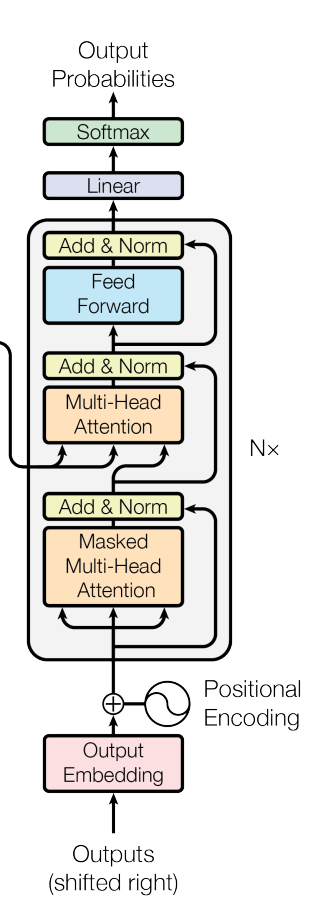
### MultiHead Cross Attention
We take the key and value pairs from the encoder output and query is taken from the decoder and then we perfrom multi head attention on them

In [ ]:
class CrossMultiHeadAttention(nn.Module):
    def __init__(self, d_model,num_heads) -> None:
        super(CrossMultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model//num_heads
        self.kv_layer = nn.Linear(d_model,2*d_model)
        self.q_layer = nn.Linear(d_model,d_model)
        self.linear_layer = nn.Linear(d_model,d_model)
    def forward(self,x,y,mask = None):
        batch_size, seq_length, d_model = x.size() # 30, 200, 512
        kv = self.kv_layer(x) # 30 x 200 x 1024
        q = self.kv_layer(y) # 30 x 200 x 512
        kv = kv.view(batch_size,seq_length,self.num_heads,2*self.head_dim) # 30 x 200 x 8 x 128 ; as 1024 // 8 = 128
        q = q.reshape(batch_size,seq_length,self.num_heads, self.head_dim) # 30 x 200 x 8 x 64
        kv = kv.permute(0,2,1,3) # 30 x 8 x 200 x 128
        q = q.permute(0,2,1,3) # 30 x 8 x 200 x 64
        k, v = torch.chunk(input=kv,chunks=2,dim=-1) # 30 x 8 x 200 x 64 each
        values, attention = scaled_dot_product_attention(q,k,v,mask=None) # attention = 30 x 8 x 200 x 200 ; values = 30 x 8 x 200 x 64; note the values is self attended values tensor
        values = values.view(batch_size,seq_length,self.num_heads*self.head_dim) # 30 x 200 x 512 ; concatenating values from all the 8 heads
        out = self.linear_layer(values)
        return out

class DecoderLayer(nn.Module):
    def __init__(self, d_model,ffn_neurons,drop_prob,num_heads) -> None:
        super(DecoderLayer,self).__init__()
        self.num_heads = num_heads
        self.drop_prob = drop_prob
        self.ffn_neurons = ffn_neurons
        self.d_model = d_model
        self.mlh = MultiHeadAttention(num_heads = num_heads, d_model = d_model)
        self.cmlh = CrossMultiHeadAttention(d_model = d_model,num_heads = num_heads)
        self.dropout = nn.Dropout(p = self.drop_prob)
        self.layer_norm_first = LayerNormalization(parameter_shape = [d_model])
        self.layer_norm_second = LayerNormalization(parameter_shape = [d_model])
        self.layer_norm_third = LayerNormalization(parameter_shape = [d_model])
        self.ffn = FeedForward(d_model = d_model, hidden_neurons = ffn_neurons, drop_prob = drop_prob)

    def forward(self,x, y, decoder_mask):
        # note that x.shape == d_model
        y_copy = deepcopy(y)
        y = self.dropout(self.mlh(y,mask=decoder_mask))
        y = self.layer_norm_first(y+y_copy)
        y_copy = deepcopy(y)
        y = self.dropout(self.cmlh(x,y,mask=None))
        y = self.layer_norm_second(y+y_copy)
        y_copy = deepcopy(y)
        y = self.dropout(self.ffn(y))
        y = self.layer_norm_third(y+y_copy)
        return y
class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x,y,mask = inputs
        for module in self._modules.values(): # to pass the output of one iteration again to the next iteration as input
            y = module(x,y,mask)
        return y
class Decoder(nn.Module):
    def __init__(self,d_model,num_heads,ffn_neurons,drop_prob,num_layers=6):
        super(Decoder,self).__init__()
        self.layers = SequentialDecoder(*[DecoderLayer(d_model,ffn_neurons,drop_prob,num_heads) for _ in range(num_layers)])
    def forward(self,x,y,mask):
        '''
        x: 30 x 200 x 512
        y: 30 x 200 x 512
        mask: 200 x 200
        '''
        y = self.layers(x,y,mask)
        return y

# Model Parameters

In [ ]:
# model parameters

d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_seq_length = 200 #max number of embedding vectors to be passed in a single time 
ffn_neurons = 2048
num_layers = 5
